<a href="https://colab.research.google.com/github/jenelaineDC/Master-Time-Series-Analysis-Forecasting/blob/main/ARIMA%2C%20SARIMA%2C%20SARIMAX/ARIMA_SARIMA_SARIMAX_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### USEFUL FUNCTIONS ###

In [ ]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train, test, and forecast data
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = root_mean_squared_error(test, predictions)
  mape = mean_absolute_percentage_error(test, predictions)

  # Print the calculated error metrics
  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

In [ ]:
# Function to plot the future
def plot_future(y, forecast, title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot the train and forecast data
  plt.plot(y, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  # add title and legend to the plot
  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()

### SET UP ###

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Python - Time Series Forecasting/Time Series Analysis/ARIMA, SARIMA and SARIMAX

/content/drive/MyDrive/Python - Time Series Forecasting/Time Series Analysis/ARIMA, SARIMA and SARIMAX


In [ ]:
!pip install pmdarima==2.0.4 -q
!pip uninstall -y numpy
!pip install --no-cache-dir --force-reinstall numpy==1.26.4

import os
os._exit(00)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 4.5 MB/s eta 0:00:00
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 537.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 48.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [ ]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from pmdarima import auto_arima, ARIMA, model_selection
import numpy as np
from sklearn.model_selection import ParameterGrid

In [11]:
# Loading the daily revenue data and set the date as uindex
df = pd.read_csv("daily_revenue.csv",
                 index_col = "date",
                 parse_dates = True,
                 dayfirst = True) #the original dataset has day first, so we just turned it to %Y-%M-%D format
df.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,"6,270,839",34.27%,1.09%
2018-01-02,"8,922,076",30.87%,1.08%
2018-01-03,"8,446,101",28.11%,1.01%
2018-01-04,"7,785,798",27.32%,0.96%
2018-01-05,"6,375,303",25.70%,0.90%


### EXPLORATORY DATA ANALYSIS ###

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   revenue        1795 non-null   object
 1   discount_rate  1795 non-null   object
 2   coupon_rate    1795 non-null   object
dtypes: object(3)
memory usage: 56.1+ KB


In [13]:
# Change revenue from object to float
df['revenue'] = df['revenue'].str.replace(',','').astype(float)

# Set Frequency to Daily
df = df.asfreq('D')

# Rename column revenue to y
df = df.rename(columns = {'revenue':'y'})
df.head()

,y,discount_rate,coupon_rate
date,,,
2018-01-01,6270839.0,34.27%,1.09%
2018-01-02,8922076.0,30.87%,1.08%
2018-01-03,8446101.0,28.11%,1.01%
2018-01-04,7785798.0,27.32%,0.96%
2018-01-05,6375303.0,25.70%,0.90%


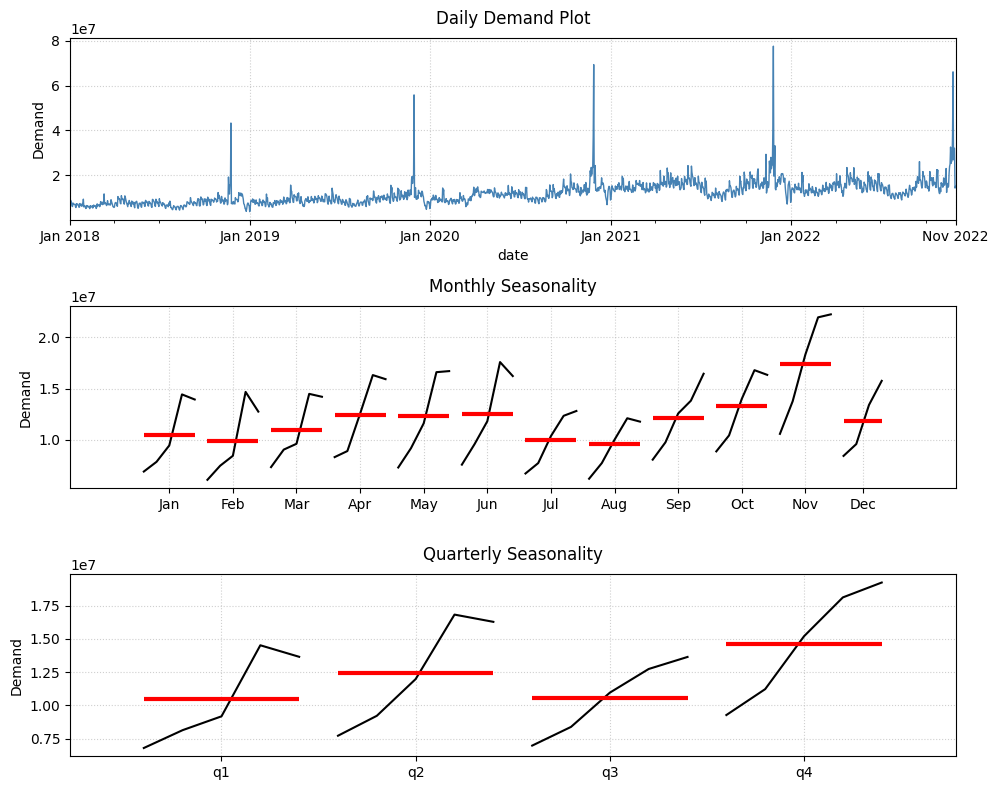

In [65]:
# Create figure with subplots
import matplotlib.dates as mdates

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.4)  # Adjust spacing between subplots

# Daily Plot
df['y'].plot(ax=ax1, color='steelblue', linewidth=1)
ax1.set_title('Daily Demand Plot', fontsize=12, pad=10)
ax1.set_ylabel('Demand', fontsize=10)
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Monthly Seasonality Plot
month_plot(df['y'].resample('ME').mean(), ylabel='Demand', ax=ax2)
ax2.set_title('Monthly Seasonality', fontsize=12, pad=10)
ax2.set_ylabel('Demand', fontsize=10)
ax2.grid(True, linestyle=':', alpha=0.6)

# Quarterly Seasonality Plot
quarter_plot(df['y'].resample('QE').mean(), ylabel='Demand', ax=ax3)
ax3.set_title('Quarterly Seasonality', fontsize=12, pad=10)
ax3.set_ylabel('Demand', fontsize=10)
ax3.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

### SEASONAL DECOMPOSITION ###

`seasonal_decompose` - To decompose a time series into its constituent parts to better understand the underlying patterns.

components

- Trend: The overall direction of the series (increasing, decreasing, or stable).
- Seasonal: Repeating patterns at fixed intervals (e.g., daily, weekly, monthly).
- Residual: The remaining variation after removing trend and seasonal components.

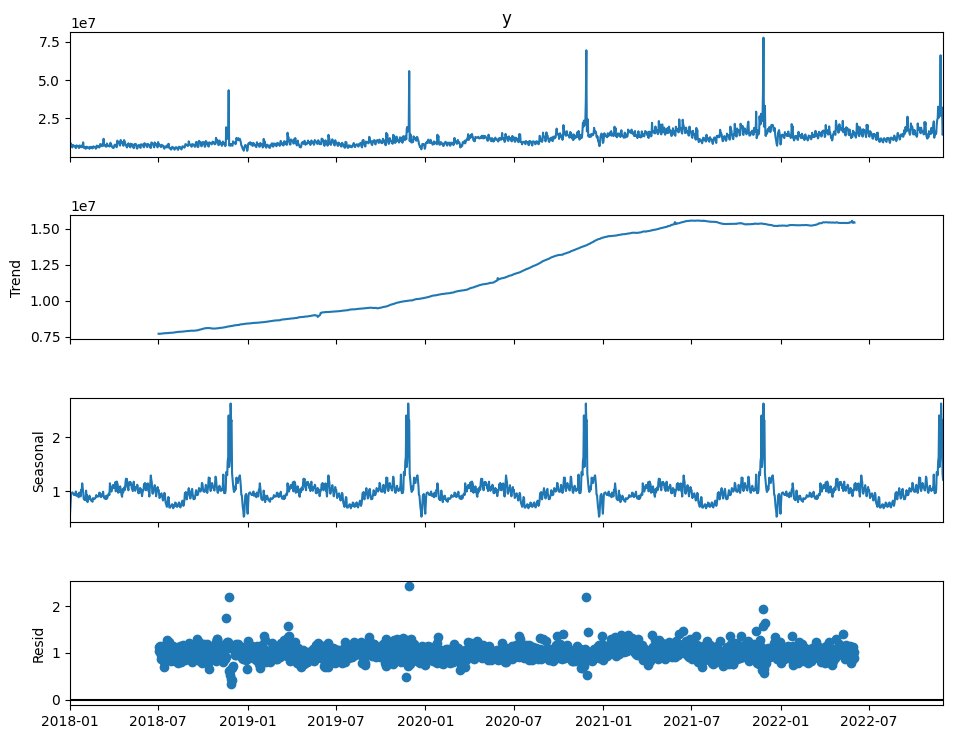

In [ ]:
# Seasonal Decomposition Plot
decomposition = seasonal_decompose(df['y'],
                                   model = 'mul', #model can be add or mul
                                   period = 365) #annual seasonality
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

### AUTO-CORRELATION ###

Autocorrelation measures the correlation between a time series and a lagged version of itself.

Purpose: To identify patterns or repeating cycles in a time series dataset.

Interpretation:
- Values range from -1 to 1.
- 1 indicates perfect positive correlation.
- -1 indicates perfect negative correlation.
- 0 indicates no correlation.

ACF Plot:
- X-axis: Lag periods
- Y-axis: Correlation coefficient

Key Features:
- At lag 0, autocorrelation is always 1 (a series is perfectly correlated with itself).
- Significant spikes at certain lags indicate repeating patterns.

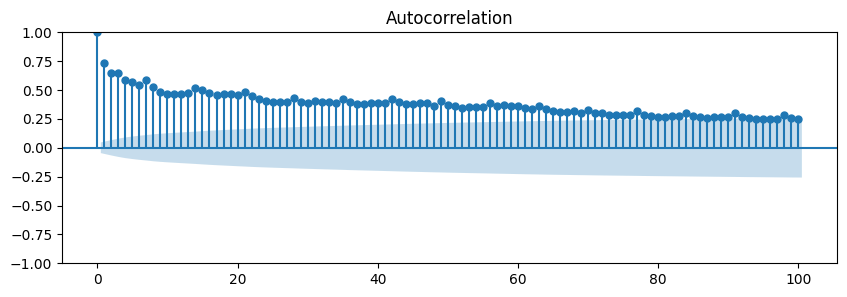

In [17]:
# ACF Plot
fig, ax = plt.subplots(figsize = (10,3))
plot_acf(df['y'], lags = 100, ax = ax)
plt.show()

### PARTIAL AUTO-CORRELATION ###

PACF measures the correlation between a time series and its lag, after removing the effects of all shorter lags.

Purpose: To identify the direct relationship between an observation and its lag, without intermediate effects.

Main Difference between ACF and PACF:
- ACF: Measures overall correlation at each lag, including indirect effects.
- PACF: Measures direct correlation at each lag, excluding indirect effects.

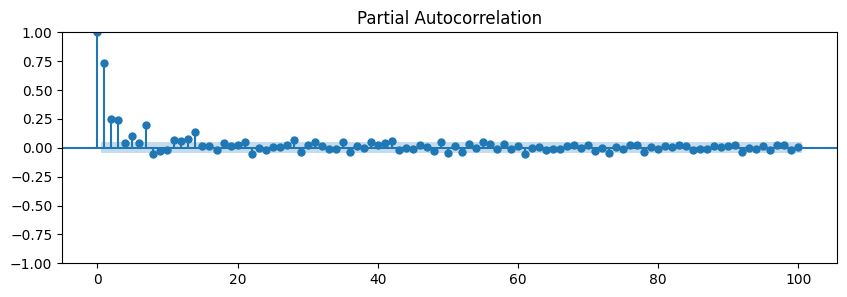

In [18]:
# PACF Plot
fig, ax = plt.subplots(figsize = (10,3))
plot_pacf(df['y'], lags = 100, ax = ax)
plt.show()

### ARIMA ###

COMPONENTS OF ARIMA MODEL

- AUTOREGRESSIVE: The AR component predicts based on past values of your time series. This uses lags. The number of lags used will also reflect the number of coefficient used in the arima model

- INTEGRATED: Data must be stationary meaning the mean, variance, covariance is stable over time. We apply differencing to make an unstationary data to be a stationary one. The Augmented Dickey-Fuller test if the data is stationary or not.

- MOVING AVERAGE: Examines the past errors by smoothing things out.

#### STATIONARITY AND AD FULLER TEST ####

For an ARIMA family of models, your df['y'] data must be stationary.  The 'I' in ARIMA stands for Integrated, which refers to the differencing required to make the time series stationary.

`Stationarity` implies that the statistical properties of the time series, such as mean and variance, do not change over time.

`adfuller` - is used to perform the Augmented Dickey-Fuller test, which is a statistical test for testing the stationarity of a time series

The test evaluates a null hypothesis that the time series is non-stationary. If the p-value obtained from the test is less than a significance level (commonly 0.05), we reject the null hypothesis and conclude that the time series is stationary.

`The d and D parameters in the ARIMA family of models refers to how many times to difference the data before fitting the AR and MA components.`

In [19]:
# Perform AD-Fuller Test
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.y)
print('p-value: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")

p-value: 0.101904
Evidence suggests that the time series is not stationary.


In [20]:
# Compute the first difference of the 'y' column in DataFrame 'df' and assign it to a new column 'y_diff'.
# '.diff()' calculates the difference between consecutive elements along the specified axis (by default axis 0).
# 'dropna()' removes any rows with NaN values resulting from differencing.
df['y_diff'] = df.y.diff().dropna()
df['y_diff']

,y_diff
date,
2018-01-01,NaN
2018-01-02,2651237.0
2018-01-03,-475975.0
2018-01-04,-660303.0
2018-01-05,-1410495.0
...,...
2022-11-26,-39180777.0
2022-11-27,4955921.0
2022-11-28,210050.0


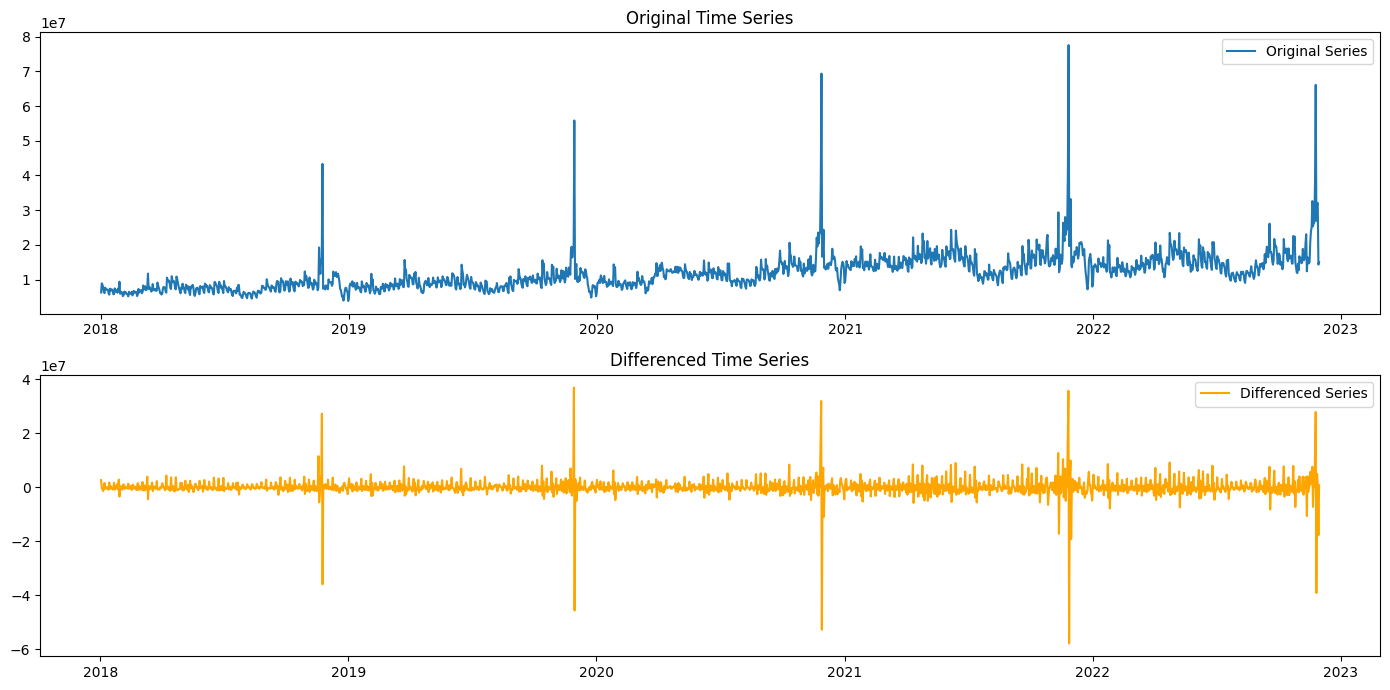

In [21]:
# Original and the Difference Plot

plt.figure(figsize=(14, 7))

# Subplot for the Original Series
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(df.y, label='Original Series')
plt.title('Original Time Series')
plt.legend()

# Subplot for the differenced series
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(df['y_diff'], label='Differenced Series', color='orange')
plt.title('Differenced Time Series')
plt.legend()

# Adjust layout to prevent overlapping of titles and labels
plt.tight_layout()
plt.show()

In [22]:
# Perform ADF test without null values
# 'result' contains the test statistic and the p-value.
result = adfuller(df['y_diff'].dropna())
print('p-value: %f' % result[1])

# Interpreting the results
if result[1] < 0.05:
    print("Evidence suggests that the time series is stationary.")
else:
    print("Evidence suggests that the time series is not stationary.")

p-value: 0.000000
Evidence suggests that the time series is stationary.


### ARIMA MODEL ###

AIC and BIC?

- It checks two things: goodness of fit and number of parameters used
- AIC seeks a well-fitting model without excessive parameters
- BIC penalizes models with more parameters. Stronger aversion to model complexity
- The model with the lowest AIC and BIC is desired
- Although this is a measure we still prefer to use MAE/RMSE/MAPE as en evaluation metric

In [23]:
# Train Test Splot
test_days = 30
train, test = df.iloc[:-test_days], df.iloc[-test_days:]

In [24]:
train.head()

,y,discount_rate,coupon_rate,y_diff
date,,,,
2018-01-01,6270839.0,34.27%,1.09%,NaN
2018-01-02,8922076.0,30.87%,1.08%,2651237.0
2018-01-03,8446101.0,28.11%,1.01%,-475975.0
2018-01-04,7785798.0,27.32%,0.96%,-660303.0
2018-01-05,6375303.0,25.70%,0.90%,-1410495.0


In [25]:
# auto_arima() from pmdarima - used to automatically select the optimal parameters for an ARIMA model based on the provided time series data.
model = auto_arima(train['y'],
                   seasonal = False) #indicates that the model should not consider seasonal components.
model.summary()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1765
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -28817.267
Date:                Fri, 29 Aug 2025   AIC                          57650.535
Time:                        08:41:16   BIC                          57694.337
Sample:                    01-01-2018   HQIC                         57666.720
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4136      0.120     -3.449      0.001      -0.649      -0.179
ar.L2          0.3017      0.053      5.671      0.000       0.197       0.406
ar.L3          0.1570      0.028      5.705      0.000       0.103       0.211
ar.L4          0.0679      0.029      2.365      0.018       0.012       0.124
ar.L5          0.0466      0.024      1.937      0.053      -0.001       0.094
ma.L1         -0.1598      0.118     -1.354      0.176      -0.391       0.071
ma.L2         -0.7423      0.108     -6.872      0.000      -0.954      -0.531
sigma2      9.084e+12   1.86e-14   4.88e+26      0.000    9.08e+12    9.08e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            580903.26
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               3.04   Skew:                             5.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        91.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.35e+42. Standard errors may be unstable.
"""

Based on the model summary. The model used SARIMAX(5, 1, 2) meaning 5 lags of AR, 1 degree of differencing and 2 for the moving average.

In [26]:
# Use the fitted ARIMA model to forecast future values.
# set the number of periods to forecast to the length of 'test'
predictions_arima = model.predict(n_periods = len(test))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


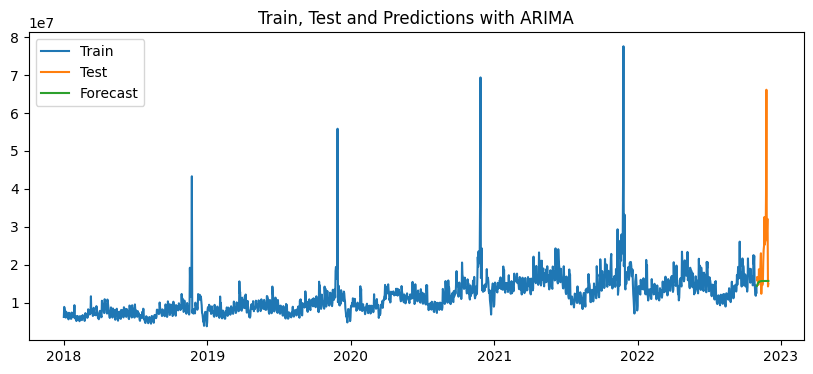

The MAE is 7267306.02
The RMSE is 12366038.29
The MAPE is 24.15 %


In [27]:
# Model assessment
model_assessment(train['y'], test['y'], predictions_arima, "ARIMA")

### SARIMA MODEL ###

Sarima handles seasonality. It provides more insights into the cyclical patterns

SARIMA COMPONENTS:

- SARIMA(p,d,q)(P,D,Q)m
- p,d,q = non-seasonal components
- P,D,Q = seasonal components
  - P = seasonal autorefressive order
  - D = seasonal differencing order
  - Q = seasonal moving average order
  - m = number of periods in each season

In [28]:
model_sarima = auto_arima(train['y'],
                          m = 7)
model_sarima.summary()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(3, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28762.051
Date:                           Fri, 29 Aug 2025   AIC                          57546.103
Time:                                   08:46:40   BIC                          57606.331
Sample:                               01-01-2018   HQIC                         57568.358
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.007e+04   4682.866      2.150      0.032     890.069    1.92e+04
ar.L1         -0.3476      0.072     -4.798      0.000      -0.490      -0.206
ar.L2          0.1857      0.032      5.722      0.000       0.122       0.249
ar.L3          0.1034      0.016      6.523      0.000       0.072       0.135
ma.L1         -0.1958      0.074     -2.656      0.008      -0.340      -0.051
ma.L2         -0.5684      0.060     -9.401      0.000      -0.687      -0.450
ar.S.L7        0.0805      0.181      0.445      0.656      -0.274       0.435
ar.S.L14       0.8712      0.172      5.071      0.000       0.535       1.208
ma.S.L7       -0.0035      0.176     -0.020      0.984      -0.349       0.342
ma.S.L14      -0.8322      0.157     -5.310      0.000      -1.139      -0.525
sigma2      9.294e+12      0.000   8.85e+16      0.000    9.29e+12    9.29e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            848640.85
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               2.85   Skew:                             5.24
Prob(H) (two-sided):                  0.00   Kurtosis:                       109.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.17e+31. Standard errors may be unstable.
"""

Based on the model summary, the model uses SARIMAX(3, 1, 2)x(2, 0, 2, 7)

In [29]:
predictions_sarima = model_sarima.predict(n_periods = len(test))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


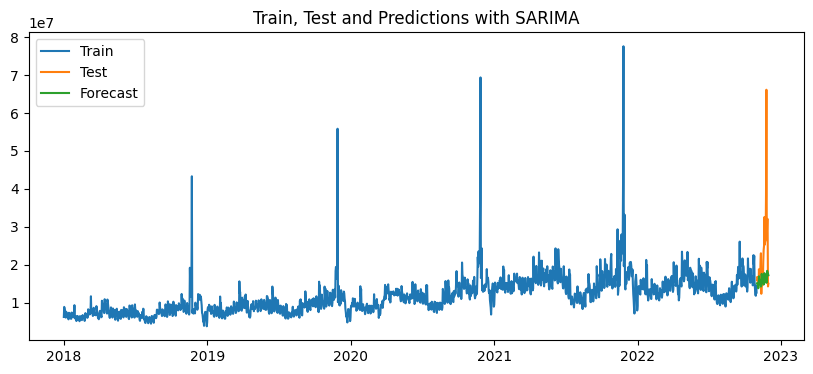

The MAE is 7210552.64
The RMSE is 12152397.97
The MAPE is 24.54 %


In [30]:
# Model assessment
model_assessment(train['y'], test['y'], predictions_sarima, "SARIMA")

### SARIMAX ###

Sarima with X - exogenous variables (external factors)

In [31]:
df['discount_rate'] = df['discount_rate'].str.replace("%", "").astype(float)
df['coupon_rate'] = df['coupon_rate'].str.replace("%", "").astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1795 entries, 2018-01-01 to 2022-11-30
Freq: D
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   y              1795 non-null   float64
 1   discount_rate  1795 non-null   float64
 2   coupon_rate    1795 non-null   float64
 3   y_diff         1794 non-null   float64
dtypes: float64(4)
memory usage: 70.1 KB


In [32]:
# Define exog test and train data
test_days = 30 # Number of days to reserve for testing
exog_train, exog_test = df.iloc[:-test_days,1:3], df.iloc[-test_days:,1:3]
exog_test.head()

,discount_rate,coupon_rate
date,,
2022-11-01,23.85,1.50
2022-11-02,20.76,0.94
2022-11-03,21.85,0.92
2022-11-04,20.17,0.88
2022-11-05,17.85,0.41


In [33]:
# Apply auto_arima
model_sarimax = auto_arima(train['y'],
                           m = 7, # m = The number of periods in each season.
                           X = exog_train) # X =  exogenous variables.
model_sarimax.summary()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28613.022
Date:                           Fri, 29 Aug 2025   AIC                          57250.045
Time:                                   08:58:35   BIC                          57315.749
Sample:                               01-01-2018   HQIC                         57274.324
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      1.641e+04   7882.029      2.082      0.037     962.227    3.19e+04
discount_rate   4.03e+05   2.35e+04     17.135      0.000    3.57e+05    4.49e+05
coupon_rate    9.229e+05   6.09e+04     15.157      0.000    8.04e+05    1.04e+06
ar.L1            -0.6527      0.155     -4.199      0.000      -0.957      -0.348
ar.L2             0.1829      0.049      3.769      0.000       0.088       0.278
ma.L1             0.1067      0.155      0.690      0.490      -0.196       0.410
ma.L2            -0.6924      0.124     -5.569      0.000      -0.936      -0.449
ar.S.L7           0.0523      0.187      0.280      0.780      -0.314       0.419
ar.S.L14          0.8999      0.178      5.066      0.000       0.552       1.248
ma.S.L7           0.0182      0.182      0.100      0.920      -0.339       0.376
ma.S.L14         -0.8500      0.161     -5.291      0.000      -1.165      -0.535
sigma2         7.655e+12      0.016    4.8e+14      0.000    7.65e+12    7.65e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):           1075189.07
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                             5.53
Prob(H) (two-sided):                  0.00   Kurtosis:                       123.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.88e+29. Standard errors may be unstable.
"""

In [34]:
predictions_sarimax = model_sarimax.predict(n_periods = len(test),
                                            X = exog_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


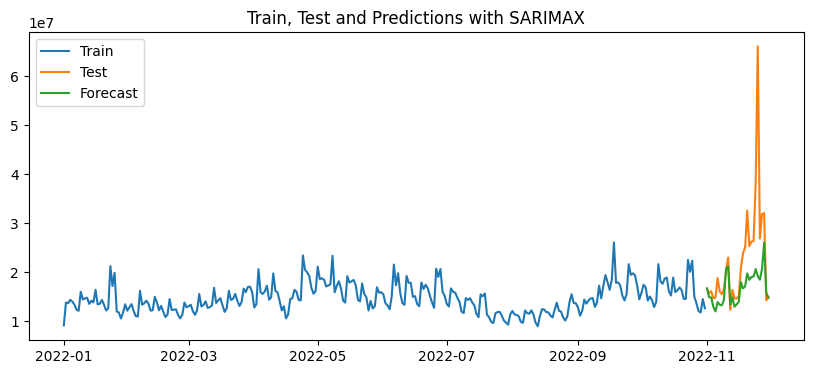

The MAE is 5716591.76
The RMSE is 10394632.17
The MAPE is 19.36 %


In [35]:
# Model assessment
model_assessment(train['y']['2022':], test['y'], predictions_sarimax, "SARIMAX")

### CROSS VALIDATION ###

In [36]:
# Define the model to do CV
# order = ([p] autoregressive order, [d] differencing order, [q] moving average order)
# seasonal_order = ([P] seasonal autoregressive order, [D] seasonal differencing order, [Q] seasonal moving average order, [m] number of periods per season)
model_cv = ARIMA(order = (2, 1, 2), seasonal_order = (2, 0, 2, 7))

In [37]:
# Define the rules for Rolling Forecast Cross-Validation (RollingForecastCV).
cv = model_selection.RollingForecastCV(h = 30, # forecast horizon
                                       step = 15, # moves the validation window by n time steps each iteration
                                       initial = df.shape[0] - 180) # starting point for the first training set

In [38]:
# Perform cross-validation scoring using specified inputs.
cv_score = model_selection.cross_val_score(model_cv,
                                           y=df['y'],  # Target variable 'y'
                                           X=df.iloc[:, 1:3],  # Explanatory variables from columns 1 and 2
                                           scoring='mean_squared_error',  # Evaluation metric: Mean Squared Error
                                           cv=cv,  # Cross-validation strategy
                                           verbose=1,  # Verbosity level
                                           error_score=10000000000000000000000  # Value to assign if fitting error occurs
                                           )


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_

In [39]:
# Calculate Root Mean Squared Error (RMSE) using cross-validated scores.
rmse = np.sqrt(np.average(cv_score))
print(f"The RMSE is {int(rmse)}")

The RMSE is 4405876


### PARAMETER TUNING ###

In [40]:
# Defining the parameters
param_grid = {'p': [1],
              'd': [0,1],
              'q': [1,2],
              'P': [1,2],
              'D': [0],
              'Q': [1]}
grid = ParameterGrid(param_grid)
len(list(grid))

8

In [41]:
# Initialize an empty list to store RMSE values for each parameter set
rmse_list = []

# Iterate over each set of parameters in the grid
for params in grid:

  # Build an ARIMA model with the current set of parameters
  model = ARIMA(order=(params['p'], params['d'], params['q']),
                seasonal_order=(params['P'], params['D'], params['Q'], 7))

  # Define the Rolling Forecast Cross-Validation strategy
  cv = model_selection.RollingForecastCV(h=30,
                                         step=15,
                                         initial=df.shape[0] - 180)

  # Perform cross-validation scoring with the ARIMA model
  cv_score = model_selection.cross_val_score(model,
                                             y=df['y'],  # Target variable 'y'
                                             X=df.iloc[:, 1:3],  # Explanatory variables from columns 1 and 2
                                             scoring='mean_squared_error',  # Evaluation metric: Mean Squared Error
                                             cv=cv,  # Cross-validation strategy
                                             verbose=1,  # Verbosity level
                                             error_score=10000000000000000000000  # Value to assign if fitting error occurs
                                             )

  # Calculate RMSE and store the error
  rmse = np.sqrt(np.average(cv_score))
  rmse_list.append(rmse)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

In [42]:
# Create a DataFrame to store the tuning results with parameters and corresponding RMSE values
tuning_results = pd.DataFrame(grid)

# Add the RMSE values calculated during parameter tuning to the DataFrame
tuning_results['rmse'] = rmse_list

tuning_results

,D,P,Q,d,p,q,rmse
0,0,1,1,0,1,1,4.062626e+06
1,0,1,1,0,1,2,4.045200e+06
2,0,1,1,1,1,1,4.404026e+06
3,0,1,1,1,1,2,4.446477e+06
4,0,2,1,0,1,1,4.025690e+06
5,0,2,1,0,1,2,4.014443e+06
6,0,2,1,1,1,1,4.386569e+06
7,0,2,1,1,1,2,4.436436e+06


In [47]:
# Save the best parameters
best_params = tuning_results[tuning_results['rmse'] == tuning_results['rmse'].min()].transpose()
best_params

,5
D,0.000000e+00
P,2.000000e+00
Q,1.000000e+00
d,0.000000e+00
p,1.000000e+00
q,2.000000e+00
rmse,4.014443e+06


### PREDICTING THE FUTURE ###

In [48]:
# target variable - daily revenue
y = df['y']
# exogenous variables
X = df.iloc[:,1:3]

In [49]:
# Fetch the best parameters
p = int(best_params.loc['p'].iloc[0])
d = int(best_params.loc['d'].iloc[0])
q = int(best_params.loc['q'].iloc[0])
P = int(best_params.loc['P'].iloc[0])
D = int(best_params.loc['D'].iloc[0])
Q = int(best_params.loc['Q'].iloc[0])

In [50]:
# Loading the future regressors data and set the date as index
df_future = pd.read_csv("future_regressors.csv",
                 index_col = "date",
                 parse_dates = True,
                 dayfirst = True)
df_future.head()

,revenue,discount_rate,coupon_rate,discount_rate_lag1,coupon_rate_lag1
date,,,,,
2022-12-01,NaN,0.1831,0.0031,0.1710,0.0032
2022-12-02,NaN,0.1995,0.0036,0.1831,0.0031
2022-12-03,NaN,0.2029,0.0032,0.1995,0.0036
2022-12-04,NaN,0.1898,0.0030,0.2029,0.0032
2022-12-05,NaN,0.1810,0.0042,0.1898,0.0030


In [51]:
# multiply all regressor columns by 100
# to make it as percentage values
X_future = df_future.iloc[:,1:3] * 100

In [52]:
# Tuned Sarimax Model with the best parameters
tuned_model = ARIMA(order = (p, d, q),
                    seasonal_order = (P, D, Q, 7))
# fit the model, add exogenous variables as X
tuned_model.fit(y, X = X)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ARIMA(order=(1, 0, 2), seasonal_order=(2, 0, 1, 7))

In [53]:
# Forecasting
# set the number of periods to forecast to the length of 'X_future'
# add future exogenous variables as X
predictions = tuned_model.predict(n_periods = len(X_future),
                                  X = X_future)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


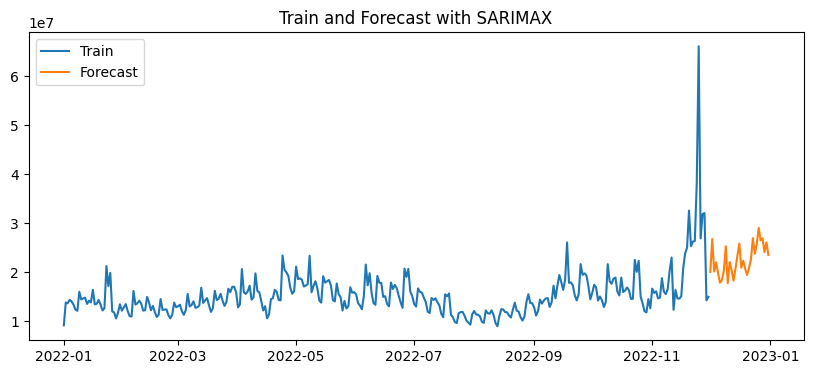

In [54]:
# Data Visualization
plot_future(y['2022':], predictions, "SARIMAX")